In [ ]:
!pip install tensorflow

In [ ]:
!pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import LSTM, Dense, Bidirectional,Dropout, Attention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Model

data = pd.read_csv('/content/SCADA_dataset.csv')
data.head()

,DateTime,Voltage Levels (V),Current Levels (A),Frequency (Hz),Power Factor,Active Power (kW),Reactive Power (kVAR),Apparent Power (kVA),Harmonics (%),Phase Angles (degrees),...,Current Imbalance (%),Circuit Breaker Status,Transformer Oil Temperature (°C),Battery State of Charge (SoC) (%),Overcurrent Relay Status,Substation Indoor Temperature (°C),Humidity Level (Indoor) (%),Smoke Detection Alarm,Real-Time Load Data (kW),Load Forecast Data (kW)
0,2021-01-01 00:00:00,232.483571,14.426254,49.895339,0.924354,866.624924,447.131333,975.174440,4.466621,318.274210,...,0.322399,Open,77.962784,68.291031,No Alarm,29.411205,51.292222,0,1068.465744,1056.404690
1,2021-01-01 01:00:00,229.308678,13.788449,49.716452,0.976345,911.689448,407.061754,998.437239,1.959836,250.839728,...,1.404187,Closed,76.541063,58.263610,No Alarm,24.710312,52.271360,1,1170.961106,965.713572
2,2021-01-01 02:00:00,233.238443,11.551313,49.624589,0.959571,935.686270,494.429411,1058.285991,1.155727,27.507754,...,1.237913,Open,81.344675,23.839609,Alarm,21.576824,61.504474,1,1420.444067,1020.945505
3,2021-01-01 03:00:00,237.615149,15.190110,49.968025,0.921469,894.542899,508.601272,1029.020044,2.125392,206.545397,...,0.512195,Open,74.873149,97.495464,Alarm,20.434843,65.096391,0,995.026814,911.374918
4,2021-01-01 04:00:00,228.829233,15.576331,50.758266,0.845694,920.650867,469.686858,1033.539435,4.772022,169.252075,...,0.080327,Open,71.184092,29.532177,No Alarm,30.777395,35.900893,1,1127.836146,934.178200


In [ ]:
data = data.drop('DateTime',axis=1)

In [ ]:
data['Circuit Breaker Status'] = data['Circuit Breaker Status'].map({'Open': 0, 'Closed': 1})
data['Overcurrent Relay Status'] = data['Overcurrent Relay Status'].map({'No Alarm': 0, 'Alarm': 1})
X = data.drop('Load Forecast Data (kW)',axis=1)
y = data['Load Forecast Data (kW)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(scaled_data, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))


In [ ]:
inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

# LSTM layers with Bidirectional
x = Bidirectional(LSTM(units=50, activation='tanh', return_sequences=True))(inputs)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=50, activation='relu', return_sequences=True))(x)
x = Dropout(0.5)(x)

# Attention layer - with query and value
attention_output = Attention()([x, x])

# Dense layer (output layer)
output = Dense(1)(attention_output)

# Model Build
rnn_model = Model(inputs, output)

# Model Compile
rnn_model.compile(optimizer='adam', loss='mse')

trained_model = rnn_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, validation_data=(X_val_reshaped, y_val), verbose=1)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 978151.1875

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


288/288 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 977739.5625 - val_loss: 413837.3750
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 226220.1250 - val_loss: 4287.6411
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 35014.6953 - val_loss: 2532.7473
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 34306.6094 - val_loss: 1855.4186
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 33948.8750 - val_loss: 1751.9869
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 32823.0469 - val_loss: 2116.9724
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 33207.6133 - val_loss: 1665.4238
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 32143.2812 - val_loss: 1171.0668
Epoch 9/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 31764.2773 - val_loss: 1327.4132
Epoch 10/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 31208.1973 - val_loss: 1442.7324
Epoch 11/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3

NameError: name 'model' is not defined

In [ ]:
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
y_pred = rnn_model.predict(X_test_reshaped)

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


114/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Mean Squared Error: 426.8993853736228
Mean Absolute Error: 18.578706686866294
R-squared: 0.9582333964075964


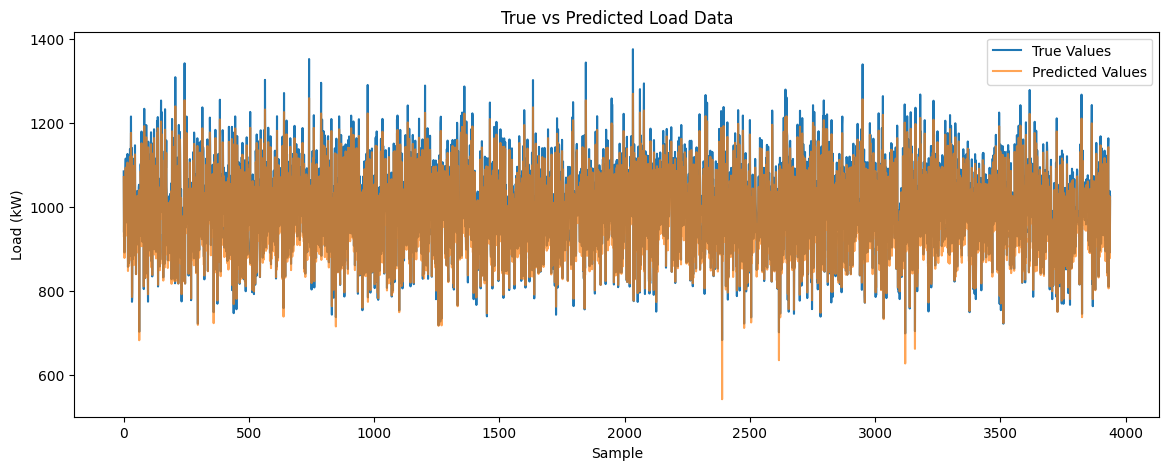

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Flattening y_pred
y_pred_flat = y_pred.flatten()

# metrics
mse = mean_squared_error(y_test, y_pred_flat)
mae = mean_absolute_error(y_test, y_pred_flat)
r2 = r2_score(y_test, y_pred_flat)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='True Values')  # Ensure y_test is a 1D array
plt.plot(y_pred_flat, label='Predicted Values', alpha=0.7)
plt.title('True vs Predicted Load Data')
plt.xlabel('Sample')
plt.ylabel('Load (kW)')
plt.legend()
plt.show()
